<a href="https://colab.research.google.com/github/umairashrafyo/CAR-PRICE-PREDICTION/blob/main/ensemble%20learning%20with%20vgg16%20vgg19%20and%20resnet%20for%20garbage%20classification%2031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as process_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as process_vgg19
from tensorflow.keras.applications.resnet50 import preprocess_input as process_resnet
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

import cv2
import random
import itertools
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [12]:
base_path = "/content/drive/MyDrive/"
labels = os.listdir(base_path + "train/")
SHAPE = (224,224,3)

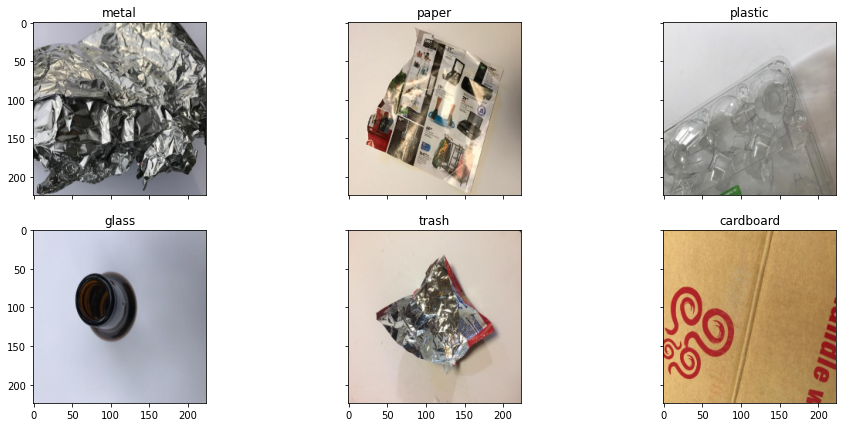

In [13]:
f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))

for ax, label in zip(axes.ravel(), labels):
    img = np.random.choice(os.listdir(base_path + "train/" + label))
    img = cv2.imread(base_path + "train/" + label + "/" + img)
    img = cv2.resize(img, SHAPE[:2])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
    ax.set_title(label)

In [14]:
train_datagen = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'
)

validation_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

In [15]:
train_batch_size = 32
val_batch_size = 32

train_generator = train_datagen.flow_from_directory(
            base_path + '/train',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = train_batch_size,
            class_mode = 'categorical',
            shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
            base_path + '/valid',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle = False
)

test_generator = test_datagen.flow_from_directory(
            base_path + '/test',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle = False
)

Found 1777 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


In [16]:
test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)

label_test.shape

(431,)

In [17]:
def import_base_model(SHAPE):

    vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = SHAPE)
    vgg19 = VGG19(weights = 'imagenet', include_top = False, input_shape = SHAPE)
    resnet = ResNet50(weights = 'imagenet', include_top = False, input_shape = SHAPE)

    for layer in vgg16.layers[:-4]:
        layer.trainable = False

    for layer in vgg19.layers[:-5]:
        layer.trainable = False

    for layer in resnet.layers[:-10]:
        layer.trainable = False
        
    return vgg16, vgg19, resnet

In [18]:
vgg16, vgg19, resnet = import_base_model(SHAPE)

94773248/94765736 [==============================] - 2s 0us/step


In [19]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



inp = Input((224,224,3))

vgg_16_process = Lambda(process_vgg16)(inp)
vgg_16 = vgg16(vgg_16_process)
x_vgg_16 = GlobalMaxPool2D()(vgg_16)
x_vgg_16 = Dense(128, activation='relu')(x_vgg_16)

resnet_process = Lambda(process_resnet)(inp)
res_net = resnet(resnet_process)
x_resnet = GlobalMaxPool2D()(res_net)
x_resnet = Dense(128, activation='relu')(x_resnet)

vgg_19_process = Lambda(process_vgg19)(inp)
vgg_19 = vgg19(vgg_19_process)
x_vgg_19 = GlobalMaxPool2D()(vgg_19)
x_vgg_19 = Dense(128, activation='relu')(x_vgg_19)

x = Concatenate()([x_vgg_16, x_resnet, x_vgg_19])
out = Dense(6, activation='softmax')(x)

model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics='accuracy')

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
model.fit(train_generator, steps_per_epoch = train_generator.samples/train_generator.batch_size,
          epochs=1, validation_data=validation_generator, validation_steps = validation_generator.samples/validation_generator.batch_size, 
          callbacks=[es], verbose = 1)

55/55 [==============================] - 1995s 36s/step - loss: 9.2362 - accuracy: 0.4251 - val_loss: 0.8222 - val_accuracy: 0.7622


In [20]:
pred_test = np.argmax(model.predict(test_generator), axis=1)

In [21]:
print(classification_report(label_test, pred_test, target_names=labels))


              precision    recall  f1-score   support

       metal       0.88      0.84      0.86        70
       paper       0.69      0.70      0.69        82
     plastic       0.70      0.62      0.66        68
       glass       0.79      0.81      0.80       108
       trash       0.62      0.78      0.69        74
   cardboard       0.67      0.41      0.51        29

    accuracy                           0.73       431
   macro avg       0.72      0.69      0.70       431
weighted avg       0.73      0.73      0.73       431



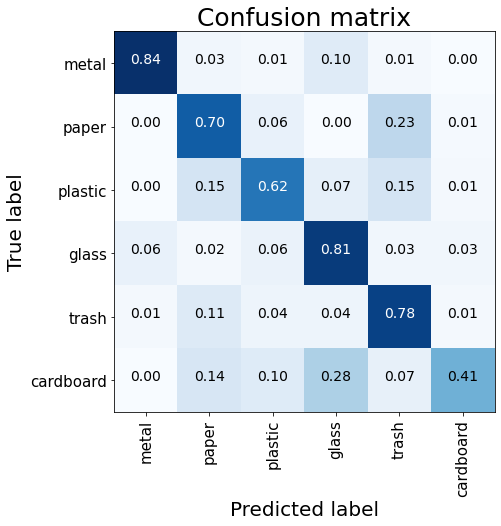

In [22]:
cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=labels)
plt.show()

In [23]:
vgg16, vgg19, resnet = import_base_model(SHAPE)


In [ ]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



inp = Input((224,224,3))

vgg_16_process = Lambda(process_vgg16)(inp)
vgg_16 = vgg16(vgg_16_process)
x_vgg_16 = GlobalMaxPool2D()(vgg_16)
x_vgg_16 = Dense(128, activation='relu')(x_vgg_16)

resnet_process = Lambda(process_resnet)(inp)
res_net = resnet(resnet_process)
x_resnet = GlobalMaxPool2D()(res_net)
x_resnet = Dense(128, activation='relu')(x_resnet)

vgg_19_process = Lambda(process_vgg19)(inp)
vgg_19 = vgg19(vgg_19_process)
x_vgg_19 = GlobalMaxPool2D()(vgg_19)
x_vgg_19 = Dense(128, activation='relu')(x_vgg_19)

x = Average()([x_vgg_16, x_resnet, x_vgg_19])
out = Dense(6, activation='softmax')(x)

model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics='accuracy')

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
model.fit(train_generator, steps_per_epoch = train_generator.samples/train_generator.batch_size,
          epochs=1, validation_data=validation_generator, validation_steps = validation_generator.samples/validation_generator.batch_size, 
          callbacks=[es], verbose = 1)

 5/55 [=>............................] - ETA: 26:10 - loss: 16.2487 - accuracy: 0.2339

In [ ]:
pred_test = np.argmax(model.predict(test_generator), axis=1)

In [ ]:
print(classification_report(label_test, pred_test, target_names=labels))

In [ ]:
cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=labels)
plt.show()

In [ ]:
vgg16, vgg19, resnet = import_base_model(SHAPE)


In [ ]:
class Linear_W(Layer):

    def __init__(self):
        super(Linear_W, self).__init__()
        
    def build(self, input_shape):
        
        self.W = self.add_weight(
                    shape=(1,1,len(input_shape)),
                    initializer='uniform',
                    dtype=tf.float32,
                    trainable=True)
        
    def call(self, inputs):

        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim

        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

In [ ]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



inp = Input((224,224,3))

vgg_16_process = Lambda(process_vgg16)(inp)
vgg_16 = vgg16(vgg_16_process)
x_vgg_16 = GlobalMaxPool2D()(vgg_16)
x_vgg_16 = Dense(128, activation='relu')(x_vgg_16)

resnet_process = Lambda(process_resnet)(inp)
res_net = resnet(resnet_process)
x_resnet = GlobalMaxPool2D()(res_net)
x_resnet = Dense(128, activation='relu')(x_resnet)

vgg_19_process = Lambda(process_vgg19)(inp)
vgg_19 = vgg19(vgg_19_process)
x_vgg_19 = GlobalMaxPool2D()(vgg_19)
x_vgg_19 = Dense(128, activation='relu')(x_vgg_19)

x = Linear_W()([x_vgg_16, x_resnet, x_vgg_19])
out = Dense(6, activation='softmax')(x)

model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics='accuracy')

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
model.fit(train_generator, steps_per_epoch = train_generator.samples/train_generator.batch_size,
          epochs=50, validation_data=validation_generator, validation_steps = validation_generator.samples/validation_generator.batch_size, 
          callbacks=[es], verbose = 1)

In [ ]:
tf.nn.softmax(model.get_weights()[-3]).numpy()


In [ ]:
pred_test = np.argmax(model.predict(test_generator), axis=1)


In [ ]:
print(classification_report(label_test, pred_test, target_names=labels))


In [ ]:
cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=labels)
plt.show()